# Qualtran + QREF & Bartiq

This notebook shows how to convert Bloqs to [QREF](https://github.com/PsiQ/qref) and use them with [Bartiq](https://github.com/PsiQ/bartiq) library for symbolic compilation.

This is not meant to be introduction to these packages, we assume that the reader has a basic understanding of what these packages allow them to do. If not, please refer to their documentation.

In [1]:
from qualtran.bloqs.data_loading.qrom import QROM
from qualtran.bloqs.state_preparation import PrepareUniformSuperposition
from qualtran.drawing import show_call_graph

import yaml
import sympy

## Basics

QREF is a format for serializing quantum algorithms for the purpose of performing resource estimations.
Bartiq is a library for obtaining symbolic expressions for QREs. 

To showcase how using QREF and Bartiq with Qualtran could be useful, we'll analyze Alias Sampling – a state preparation method described in [Encoding Electronic Spectra in Quantum Circuits with Linear T Complexity](https://arxiv.org/abs/1805.03662).

Let's start from the basics – converting Bloq to QREF and compiling costs using Bartiq.

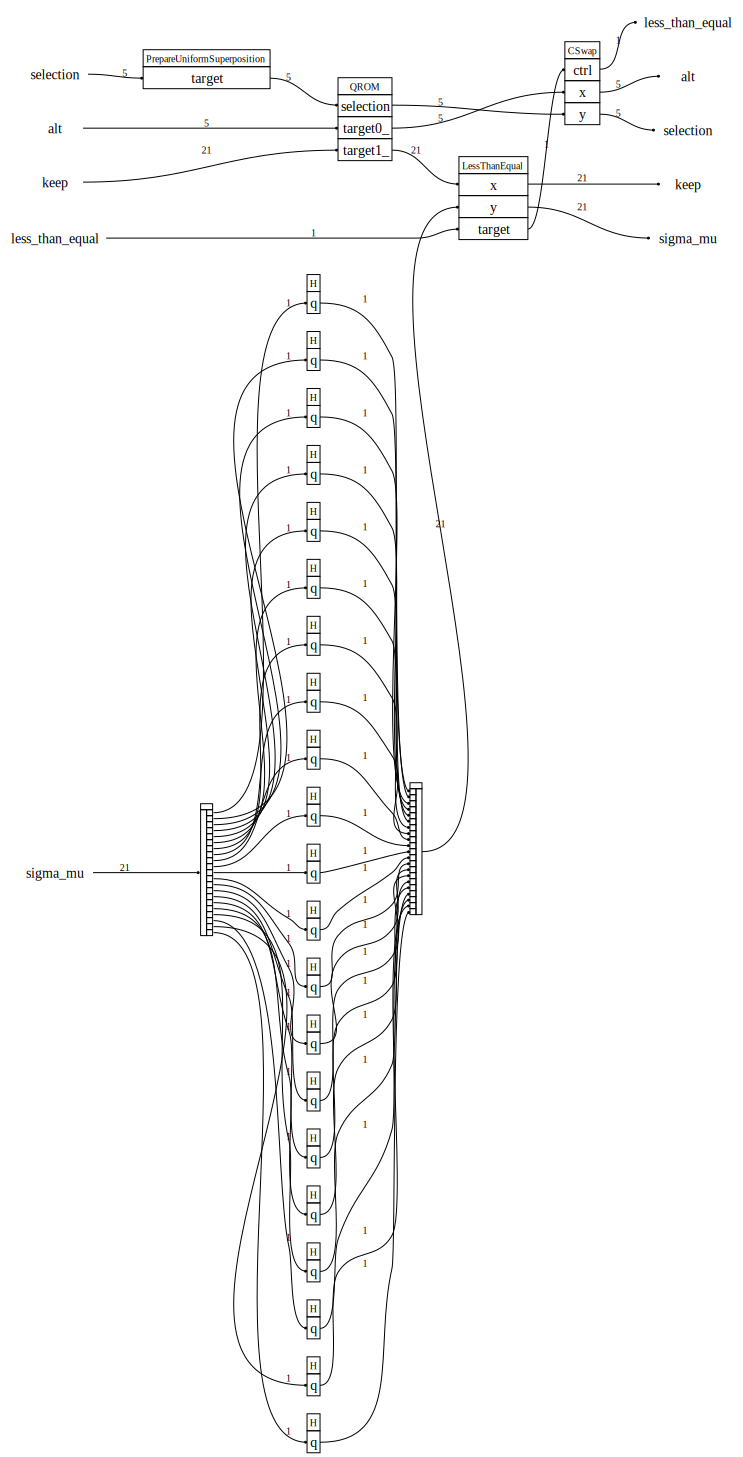

In [2]:
from qualtran.bloqs.state_preparation import StatePreparationAliasSampling
from qualtran.drawing.graphviz import PrettyGraphDrawer

probs_list = list(range(24))
bloq = StatePreparationAliasSampling.from_probabilities(probs_list).decompose_bloq()
PrettyGraphDrawer(bloq).get_svg()

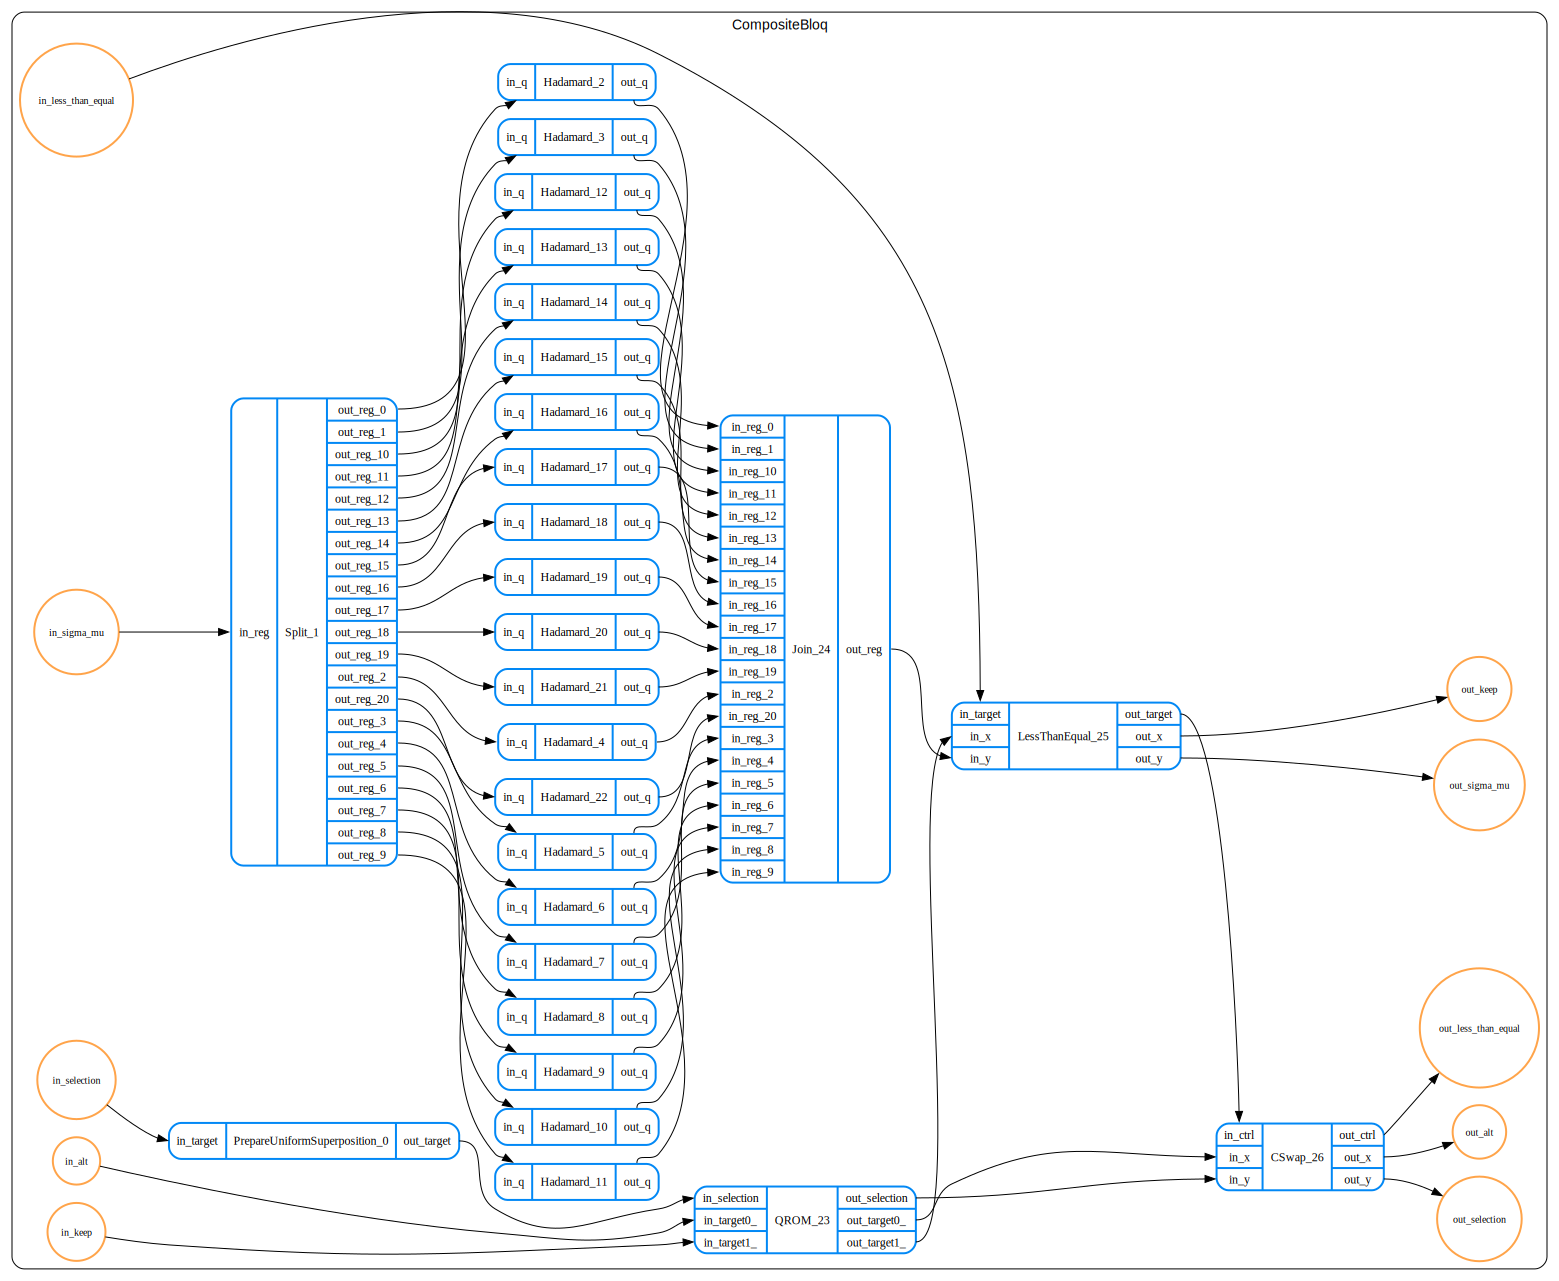

In [3]:
from qualtran.qref_interop import bloq_to_qref
from qref.experimental.rendering import to_graphviz

# We can easily convert it to QREF representation with the following code:
qref_definition = bloq_to_qref(bloq)
to_graphviz(qref_definition)

In [4]:
from pprint import pprint
# We can check that the resources for both representations are the same:
pprint(bloq.t_complexity())
pprint(qref_definition.program.resources)

TComplexity(t=307, clifford=1770, rotations=2)
[ResourceV1(name='clifford', type='additive', value=1770),
 ResourceV1(name='rotations', type='additive', value=2),
 ResourceV1(name='t', type='additive', value=307)]


These are only the "top-level" resources, we can also see what are the resources of the building blocks, for example Uniform State Preparation:

In [5]:
USP_bloq = [bloq_inst.bloq for bloq_inst in bloq.bloq_instances if bloq_inst.bloq.pretty_name() == "PrepareUniformSuperposition"][0]
pprint(USP_bloq.t_complexity())
pprint(qref_definition.program.children.by_name["PrepareUniformSuperposition_0"].resources)

TComplexity(t=20, clifford=106, rotations=2)
[ResourceV1(name='clifford', type='additive', value=106),
 ResourceV1(name='rotations', type='additive', value=2),
 ResourceV1(name='t', type='additive', value=20)]


Now we can take the QREF definition and pass it to Bartiq.
However, it would be trivial as all the resources are already there. For this reason, before passing it to Bartiq, we'll remove the top level resources in QREF.

In [6]:
from bartiq.integrations.qref import qref_to_bartiq
from bartiq import compile_routine

qref_definition.program.resources =  [] 
bartiq_routine = qref_to_bartiq(qref_definition)
compiled_routine = compile_routine(bartiq_routine)
pprint(compiled_routine.resources)

{'clifford': <Resource name="clifford" value="1770">,
 'rotations': <Resource name="rotations" value="2">,
 't': <Resource name="t" value="307">}


As we can see, Bartiq correctly reconstructed the costs from the subroutines.

## Writing custom USP implementation

So far so good, but we used Bartiq to derive the same information we already had in Qualtran.

There are two limitations of Qualtran implementation, with which Bartiq can help us, let's see what these are.

### Numeric implementation

The example above is purely numeric. We can get the symbolic cost of the whole `StatePreparationAliasSampling` (see snippet below) but we can't decompose it using `decompose_bloq()`.

```
import sympy
N, M, eps = sympy.symbols("N M eps")
bloq = StatePreparationAliasSampling.from_n_coeff(n_coeff=N, sum_of_unnormalized_probabilites=M, precision=eps)
pprint(bloq.t_complexity())
bloq.decompose_bloq()
```

### Resources tied to a specific implementation

At the time of writing, if we look at the source code of [PrepareUniformSuperposition](https://github.com/quantumlib/Qualtran/blob/c0a3a94d712f4eebb1cad119fc507a6cd9a7d8e7/qualtran/bloqs/state_preparation/prepare_uniform_superposition.py#L44), we'll see the following information in the docstring:

> Performs a single round of amplitude amplification and prepares a uniform superposition over the first $n$ basis states $|0>, |1>, ..., |n - 1>$. The expected T-complexity should be $10 * log(L) + 2 * K$ T-gates and $2$ single qubit rotation gates, where $n = L * 2^K$.
>
> However, the current T-complexity is $12 * log(L)$ T-gates and $2 + 2 * (K + log(L))$ rotations
because of two open issues:
> 
> - https://github.com/quantumlib/Qualtran/issues/233 and
> - https://github.com/quantumlib/Qualtran/issues/235

We see that in Qualtran we're sometimes tied with the resources to a specific implementation, even if we know it's incorrect.



Below we'll see how we can quickly create an alternative implementation of USP with QREF

In [7]:
from qualtran.bloqs.state_preparation import PrepareUniformSuperposition
N = sympy.symbols("N")
USP_bloq = PrepareUniformSuperposition(N)
# We see that contrary to the docstring, number of rotations is already correct
USP_bloq.t_complexity()

TComplexity(t=12*ceiling(log2(N - 1)) - 4, clifford=52*ceiling(log2(N - 1)) - 9, rotations=2)

In [8]:
# Now we create two QREF definitions based on the PrepareUniformSuperposition bloq
usp_1_qref = bloq_to_qref(USP_bloq) # this will be left unchanged
usp_2_qref = bloq_to_qref(USP_bloq) # this will be updated

In [9]:
# We check if the expressions are 
usp_1_qref.program.resources

[ResourceV1(name='clifford', type='additive', value='52*ceiling(log2(N - 1)) - 9'),
 ResourceV1(name='rotations', type='additive', value='2'),
 ResourceV1(name='t', type='additive', value='12*ceiling(log2(N - 1)) - 4')]

In [10]:
# We'll implement the new version of USP straight in QREF, it's based on `usp_1_qref.model_dump()`
# Note that we omit Clifford gates here, as the expression for them is not mentioned in the docstring.
from qref import SchemaV1
import math
port_size = math.ceil(math.log2(len(probs_list)))

usp_2_qref = SchemaV1(
    program={
        "name": "PrepareUniformSuperposition",
        "input_params": ["N"],
        "ports": [
            {"direction": "input", "name": "in_target", "size": port_size},
            {"direction": "output", "name": "out_target", "size": port_size},
        ],
        "resources": [
            {"name": "t", "type": "additive", "value": "10*ceiling(log2(L)) + 2*k"},
            {"name": "rotations", "type": "additive", "value": "2"},
        ],
        "local_variables": {"k": "multiplicity(2, N)", "L": "N/2**k"},
    },
    version="v1",
)

In [11]:
usp_1_bartiq = qref_to_bartiq(usp_1_qref)
compile_routine(usp_1_bartiq).resources["t"]

<Resource name="t" value="12*ceiling(log2(N - 1)) - 4">

In [12]:
usp_2_bartiq = qref_to_bartiq(usp_2_qref)
compile_routine(usp_2_bartiq).resources["t"]

<Resource name="t" value="2*multiplicity(2, N) + 10*ceiling(log2(N/2 ^ multiplicity(2, N)))">

## Updating Alias Sampling

In [13]:
bloq = StatePreparationAliasSampling.from_probabilities(probs_list).decompose_bloq()

In [14]:
# We export our Alias Sampling bloq to QREF and remove top-level resources so we can re-compute them later.
qref_as_1 = bloq_to_qref(bloq)
qref_as_2 = bloq_to_qref(bloq)
qref_as_1.program.resources = []
qref_as_2.program.resources = []

In [15]:
# Before we put the subroutine in the right place, we need to make sure it's named correctly, otherwise 
# some of the connections will be invalid.
usp_2_qref.program.name = "PrepareUniformSuperposition_0"
qref_as_2.program.children.by_name["PrepareUniformSuperposition_0"] = usp_2_qref.program

In [16]:
bartiq_as_1 = qref_to_bartiq(qref_as_1)
compile_routine(bartiq_as_1).resources["t"]

<Resource name="t" value="307">

In [17]:
bartiq_as_2 = qref_to_bartiq(qref_as_2)
compile_routine(bartiq_as_2).resources["t"]

/Users/mstechly/Documents/code/2024-06-26-qualtran-conversion/bartiq/src/bartiq/compilation/_compile.py:117: UserWarning: Found the following issues with the provided routine after the compilation has finished: ["Input param N found in subroutine: CompositeBloq.PrepareUniformSuperposition_0, which is not among top level params: {'PrepareUniformSuperposition_0.N'}."]
  warnings.warn(


<Resource name="t" value="2*multiplicity(2, PrepareUniformSuperposition_0.N) + 10*ceiling(log2(PrepareUniformSuperposition_0.N/2 ^ multiplicity(2, PrepareUniformSuperposition_0.N))) + 287">

Since the top-level routine does not have knowledge about it's children parameter, the parameter `N` from USP routine got namespaced and we see: `PrepareUniformSuperposition_0.N` in the expression. To get rid of that, we'll make a tiny update:

In [18]:
from qref.schema_v1 import ParamLinkV1
qref_as_2.program.input_params = ["N"]
qref_as_2.program.linked_params = [{"source": "N", "targets": ["PrepareUniformSuperposition_0.N"]}]

In [19]:
bartiq_as_2 = qref_to_bartiq(qref_as_2)
compiled_as_2 = compile_routine(bartiq_as_2)
compiled_as_2.resources["t"]

<Resource name="t" value="2*multiplicity(2, N) + 10*ceiling(log2(N/2 ^ multiplicity(2, N))) + 287">

In order to get the value of these resources for a specific value of `N`, we can use Bartiq's `evaluate` method:

In [20]:
from bartiq import evaluate

N_value = len(probs_list)

assignments = {f"N={N_value}"}

evaluate(compiled_as_2, assignments).resources["t"]

<Resource name="t" value="313">

# Custom functions

Another case where Bartiq can be useful is when the cost of a particular routine is given by a custom function.
Let's say that we have an idea for defining cost of USP by using a recursive function `foo` as defined below.

In [21]:
def foo(n):
    if n < 10:
        return n
    else:
        return foo(n-3) 

In [22]:
import copy
usp_3_qref = copy.copy(usp_2_qref)
usp_3_qref.program.resources = [{"name": "t", "type": "additive", "value": "2*foo(N)"}]

usp_3_bartiq = qref_to_bartiq(usp_3_qref)
compiled_usp_3 = compile_routine(usp_3_bartiq)
compiled_usp_3.resources

{'t': <Resource name="t" value="2*foo(N)">}

In [23]:
assignments = {"N=101"}
functions_map = {"foo": foo}
evaluate(compiled_usp_3, assignments, functions_map=functions_map).resources

{'t': <Resource name="t" value="16">}

We see that in such case we can both use custom functions in the symbolic expressions for the costs, as well as evaluate them with specific numeric values.

## Closing remarks

Thank you for going through this notebook!
QREF and Bartiq are still in beta, and there's so much more we could do to make the integration with Qualtran better.
If you have specific usecase in mind or if you encounter any issues, please leave an issue in any of the involved projects and we'll love to help you make it work.